In [14]:
import torch
import os
from torch.utils.data import DataLoader
from modules.backbones import Swin
from modules.datasets import MultiLabelDataset,AugmentingDataset
import warnings
from tqdm import tqdm 
import numpy as np

warnings.filterwarnings("ignore", ".*does not have many workers.*") # we want to run Single-Core in the Notebook -> Ignore this warning
warnings.simplefilter(action='ignore', category=FutureWarning)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
SAVE_DIR = "./runs/zero_shot"

In this Notebook we take a look at the Zero-Shot Performance of our embeddings. 

In [15]:
#Take 100 images per class
dataset = MultiLabelDataset(
    "./Carparts",
    max_size_per_class=100,
    label_index = 1
)
print(f"Classes: {len(dataset)}")

800

In [16]:
#Split them 50/50-> 50 to calculate the embeddings for the KNN-Search and 50 to validate.
BATCH_SIZE = 128
train_size = int(0.5 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, test_size],generator=torch.Generator().manual_seed(42))
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE,pin_memory=True)

In [17]:
#load the tiny_imagenet pretrained model
model = Swin()
model.load_state_dict(torch.load(os.path.join(SAVE_DIR,"tiny_imagenet","checkpoints",f"epoch_0.pth")))
model = model.to(DEVICE)


In [18]:
#build the knn
from modules.knn import KNN

knn = KNN(model,train_loader,os.path.join(SAVE_DIR,"tiny_imagenet"))

Building Embeddings: 100%|██████████| 4/4 [00:05<00:00,  1.38s/it]


In [19]:
model.eval()
embeddings = []
labels = []

with torch.no_grad():
    for batch in tqdm(val_loader):
        img,label = batch
        embedding = model(img.to(DEVICE)).cpu().numpy()
        embeddings.append(embedding)  
        labels.append(label)
        
embeddings = np.vstack(embeddings)     
labels = np.vstack(labels).reshape(-1)

100%|██████████| 4/4 [00:05<00:00,  1.32s/it]


In [20]:
from sklearn.metrics import f1_score

predictions = knn.querry_labels(embeddings)
print(f"F1-Score: {f1_score(predictions,labels,average='macro'):.3f}")

F1-Score: 0.865


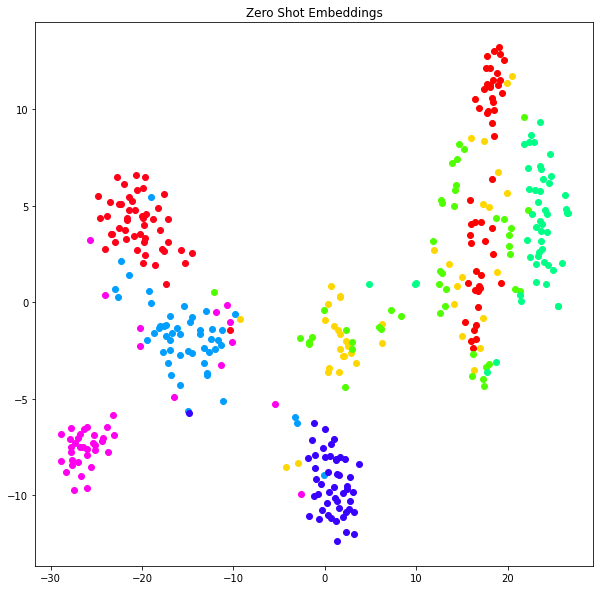

In [21]:
import matplotlib.pyplot as plt
from modules.plotting import plot_tsne

plt.figure(figsize=(10,10))
plot_tsne(embeddings,labels,8,max_points_per_class=50)
plt.title("Zero Shot Embeddings")
plt.show()